In [1]:
import sys
sys.path.append('..')

from NRC import NRC, recordModule
from distributed import Client
from utils import returnSpec
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import MultipleLocator
from tqdm import tqdm
import os
import numpy as np
import pickle
from mne.decoding import ReceptiveField
import seaborn as sns
import matplotlib.pyplot as plt

/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numba/core/types/__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  long_ = _make_signed(np.long)
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numba/core/types/__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  long_ = _make_signed(np.long)


In [59]:
expName = 'compare'

srate = 250
winLEN = 0.5

tmin= -0
tmax = 0.4

key = 'SSVEP'
dir = '../datasets/%s.pickle' % expName
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[-5]
chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ', 'O2','PO3']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub[key]['X'][:, chnINX]
y = sub[key]['y']
S = sub[key]['STI']
_class = np.unique(y).tolist()
sub['name']

'yaofeifan'

In [25]:
winLEN = 0.2
srate=250
targetNUM = 40

freqs = np.linspace(8.0, 15.8, 40)
phase=[i* np.pi for i in [0, 0.35, 0.70, 1.05, 1.40,1.75, 0.1, 0.45, 0.80, 1.15,1.50, 1.85, 0.20, 0.55, 0.9, 1.25, 1.60, 1.95, 0.30, 0.65, 1.0, 1.35, 1.70, 0.05, 0.40, 0.75, 1.10, 1.45, 1.80, 0.15, 0.50, 0.85, 1.20, 1.55, 1.90, 0.25, 0.60, 0.95, 1.30, 1.65]]

ts = np.arange(0,0.5,step=1/250)

S = np.stack([[np.sin(2*np.pi*f*t+omega) for t in ts] for (f,omega) in zip(freqs,phase)])

S = []
for (f,omega) in zip(freqs,phase):
    
    thisTarget = []
    for harmonic in np.arange(1,3):

        s = [np.sin(2*np.pi*f*harmonic*t+omega) for t in ts]
        thisTarget.append(s)

    S.append(np.stack(thisTarget).mean(axis=0))

S = np.stack(S)

In [26]:
M = np.zeros((40,40))
for row,i in enumerate(S):
    for col,k in enumerate(S):
        M[row,col] = np.corrcoef(i,k)[0,1]

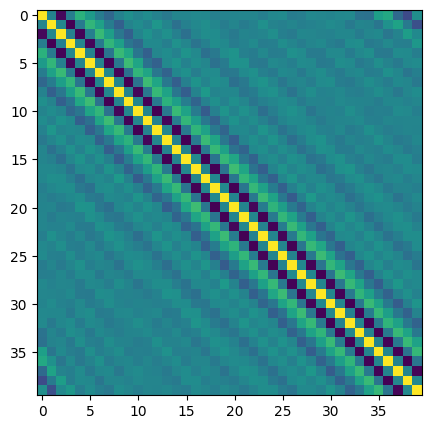

In [27]:
plt.figure(figsize=(5,5))

plt.imshow(M)

In [61]:
from modeling import Code2EEG
code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,_class),estimator=0.9
,padding=True,n_band=1,component=1)
code2EEG.fit(X,y)

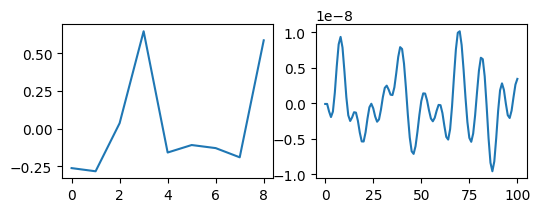

In [62]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(6,2))
ax2.plot(code2EEG.trf[0])
ax1.plot(code2EEG.enhancer.filters[0])

In [16]:
lists = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying','lijiayang','libowen','zhouyuqing']

trfs = []

Xs = []
ys = []
Ss = []

i=1
for sub in tqdm(wholeset):

    if sub['name'] in lists:
        
        X = sub[key]['X'][:, chnINX]
        y = sub[key]['y']
        
        S = sub[key]['STI']

        Xs.append(X)
        ys.append(y+i*40)
        Ss.append(S)

        i=i+1
    

Xs = np.concatenate(Xs,axis=0)
ys = np.concatenate(ys,axis=-1)
Ss = np.concatenate(Ss,axis=0)

100%|██████████| 15/15 [00:00<00:00, 3422.43it/s]


In [24]:
key='SSVEP'
lists = ['yangyuxing', 'xuwenjia', 'jingyi',
         'fanzixiao', 'wangchaoying', 'lijiayang', 'libowen', 'zhouyuqing']

trfs = []

Xs = []
ys = []
Ss = []

i = 1
for sub in tqdm(wholeset):

    if sub['name'] in lists:

        X = sub[key]['X'][:, chnINX]
        y = sub[key]['y']

        # S = sub[key]['STI']

        Xs.append(X)
        ys.append(y)
        Ss.append(S)

        i = i+1


Xs = np.concatenate(Xs, axis=0)
ys = np.concatenate(ys, axis=-1)
Ss = np.concatenate(Ss, axis=0)


100%|██████████| 15/15 [00:00<00:00, 2781.37it/s]


In [29]:
from modeling import Code2EEG
code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(ys)),estimator=0.9
,padding=True,n_band=1,component=1)
code2EEG.fit(Xs,ys)

# STI = np.stack([S[_class.index(i), :125] for i in y])        
# trfs.append(code2EEG.trf)


In [26]:
wn = code2EEG.trf[0]

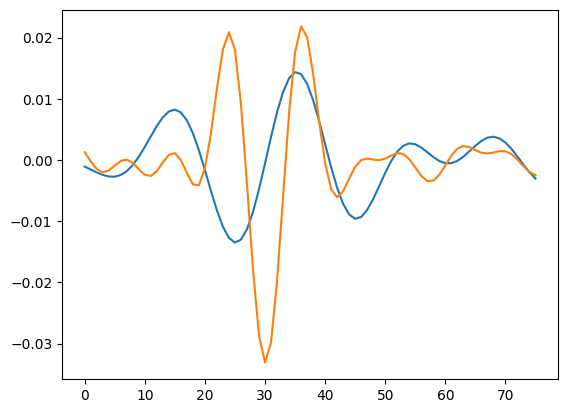

In [31]:
plt.plot(code2EEG.trf[0])
plt.plot(wn)

In [21]:
x = np.squeeze(np.stack(trfs))
i = 0
from scipy.stats import zscore
plt.plot(zscore(x[i]))
# plt.plot(zscore(x1[i]))

ValueError: need at least one array to stack